# Alpha#1 因子回测测试

测试 Alpha#1 因子，使用 Mark-to-Market 回测系统

公式: (rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)


In [1]:
# 导入库和设置路径
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目根目录到路径
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))

# 重新加载模块（确保使用最新代码）
import importlib
if 'research.factors.alpha1' in sys.modules:
    importlib.reload(sys.modules['research.factors.alpha1'])
if 'research.backtest.signals' in sys.modules:
    importlib.reload(sys.modules['research.backtest.signals'])
if 'research.backtest.portfolio_bt' in sys.modules:
    importlib.reload(sys.modules['research.backtest.portfolio_bt'])
if 'research.backtest.factor_test' in sys.modules:
    importlib.reload(sys.modules['research.backtest.factor_test'])

# 导入项目模块
from research.factors.alpha1 import Alpha1Factor
from research.backtest.signals import normalize_factor, normalize_positions
from research.backtest.portfolio_bt import simulate_portfolio, calculate_metrics, load_costs_config, load_backtest_config, create_synthetic_benchmark
from research.backtest.factor_test import factor_returns_by_quantile, calculate_ic, calculate_ir, plot_ic_distribution

print("✓ 所有模块导入成功！")
print(f"项目根目录: {project_root}")


✓ 所有模块导入成功！
项目根目录: C:\Users\Chengyu Gong\Klpha\KlphaOriginal


## 步骤 1: 加载数据


In [2]:
# 加载数据
data_path = project_root / "data" / "processed" / "data.pkl"

print(f"加载数据: {data_path}")
with open(data_path, 'rb') as f:
    data = pickle.load(f)

print(f"\n数据包含的字段: {list(data.keys())}")
print(f"\n数据统计:")
for key, df in data.items():
    if isinstance(df, pd.DataFrame):
        print(f"  {key}: {df.shape[0]} 行 × {df.shape[1]} 列")
        print(f"    日期范围: {df.index.min()} 到 {df.index.max()}")

# 创建合成基准（等权重组合），消除幸存者偏差
print(f"\n创建合成基准（等权重组合）...")
synthetic_benchmark = create_synthetic_benchmark(data['close'])
print(f"  合成基准数据: {len(synthetic_benchmark)} 个交易日")
print(f"  日期范围: {synthetic_benchmark.index.min()} 到 {synthetic_benchmark.index.max()}")
print(f"  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池")


加载数据: C:\Users\Chengyu Gong\Klpha\KlphaOriginal\data\processed\data.pkl

数据包含的字段: ['close', 'open', 'high', 'low', 'volume']

数据统计:
  close: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  open: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  high: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  low: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  volume: 2763 行 × 501 列
    日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

创建合成基准（等权重组合）...
  合成基准数据: 2762 个交易日
  日期范围: 2015-01-05 00:00:00-05:00 到 2025-12-26 00:00:00-05:00
  说明: 基于当前股票池构建等权重指数，确保基准和策略使用相同的股票池


## 步骤 2: 计算 Alpha#1 因子


In [3]:
# 计算 Alpha#1 因子
print("计算 Alpha#1 因子")

# 创建 Alpha#1 因子（参数可调）
alpha1_factor = Alpha1Factor(
    stddev_period=20,    # 计算标准差的时间窗口（20天）
    argmax_window=5,     # ArgMax的时间窗口（5天）
    power=2.0            # SignedPower的幂次（2.0，即平方）
)

print(f"\nAlpha#1 参数:")
print(f"  标准差周期: {alpha1_factor.stddev_period} 天")
print(f"  ArgMax窗口: {alpha1_factor.argmax_window} 天")
print(f"  幂次: {alpha1_factor.power}")

# 计算因子值
print(f"\n开始计算 Alpha#1 因子（这可能需要一些时间）...")
factor_values = alpha1_factor.calculate(data)

print(f"\n✓ Alpha#1 因子计算完成")
print(f"  因子形状: {factor_values.shape}")
print(f"  日期范围: {factor_values.index.min()} 到 {factor_values.index.max()}")

# 查看因子值统计
print(f"\n因子值统计:")
alpha1_vals = factor_values.stack()
print(alpha1_vals.describe())


计算 Alpha#1 因子

Alpha#1 参数:
  标准差周期: 20 天
  ArgMax窗口: 5 天
  幂次: 2.0

开始计算 Alpha#1 因子（这可能需要一些时间）...

✓ Alpha#1 因子计算完成
  因子形状: (2763, 501)
  日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

因子值统计:
count    1.335455e+06
mean     1.034479e-03
std      2.886746e-01
min     -4.980040e-01
25%     -2.489879e-01
50%      1.035197e-03
75%      2.510121e-01
max      5.000000e-01
dtype: float64


## 步骤 3: 因子归一化处理


In [4]:
# Alpha#1 因子已经经过排名和减去0.5的处理，值域在[-0.5, 0.5]之间
# 可以直接使用，或者进行进一步的标准化
print("=" * 60)
print("Alpha#1 因子处理")
print("=" * 60)

# Alpha#1 因子已经经过排名处理，值域在[-0.5, 0.5]
# 可以直接使用，或者进行Z-score标准化以更好地适应组合构建
factor_clean = factor_values.copy()

# 可选：进行横截面Z-score标准化（进一步标准化）
print("\n进行横截面Z-score标准化...")
factor_normalized = normalize_factor(factor_clean, method='zscore')

print(f"\n归一化后因子统计:")
norm_vals = factor_normalized.stack()
print(norm_vals.describe())
print("=" * 60)


Alpha#1 因子处理

进行横截面Z-score标准化...

归一化后因子统计:
count    1.335455e+06
mean    -4.257813e-18
std      9.989654e-01
min     -1.726871e+00
25%     -8.651502e-01
50%      3.751823e-17
75%      8.651502e-01
max      1.726871e+00
dtype: float64


## 步骤 4: 运行回测


In [5]:
# 加载回测配置
backtest_config = load_backtest_config()
costs_config = load_costs_config()

print("=" * 60)
print("回测配置")
print("=" * 60)
print(f"window_size: {backtest_config.get('window_size', 1)}")
print(f"booksize: {backtest_config.get('booksize', 1.0)}")
print(f"upper_bound: {backtest_config.get('upper_bound', 0.1)}")
print("=" * 60)

# 运行回测
print(f"\n运行回测 (window_size={backtest_config.get('window_size', 1)})...")
bt_results = simulate_portfolio(
    alpha=factor_normalized,  # 传入归一化后的因子值（原始信号）
    prices=data['close'],
    volume=data['volume'],
    costs=costs_config,
    booksize=backtest_config.get('booksize', 1.0),
    upper_bound=backtest_config.get('upper_bound', 0.1),
    window_size=backtest_config.get('window_size', 1)
)

print("✓ 回测完成")
print(f"日期范围: {bt_results.index.min()} 到 {bt_results.index.max()}")
print(f"\n回测结果概览:")
print(bt_results.describe())


回测配置
window_size: 14
booksize: 1.0
upper_bound: 0.1

运行回测 (window_size=14)...
✓ 回测完成
日期范围: 2015-01-02 00:00:00-05:00 到 2025-12-26 00:00:00-05:00

回测结果概览:
               ret      ret_net          tvr     dailypnl  dailypnl_net  \
count  2763.000000  2763.000000  2763.000000  2763.000000   2763.000000   
mean      0.000685     0.000550     0.090220     0.000685      0.000550   
std       0.011601     0.011600     0.019446     0.011601      0.011600   
min      -0.125195    -0.125320     0.021656    -0.125195     -0.125320   
25%      -0.004030    -0.004151     0.085870    -0.004030     -0.004151   
50%       0.000946     0.000804     0.090762     0.000946      0.000804   
75%       0.006287     0.006136     0.095187     0.006287      0.006136   
max       0.112398     0.112269     1.000000     0.112398      0.112269   

          long_size  
count  2.763000e+03  
mean   1.000000e+00  
std    5.963974e-16  
min    1.000000e+00  
25%    1.000000e+00  
50%    1.000000e+00  
75%    1.000000e

## 步骤 5: 计算性能指标


In [6]:
# 计算性能指标（使用费后收益率，包含 CAPM 指标）
# 使用合成基准（等权重组合）消除幸存者偏差
metrics = calculate_metrics(
    bt_results['ret_net'], 
    risk_free_rate=0.0,
    benchmark_returns=synthetic_benchmark
)

print("=" * 60)
print("回测性能指标")
print("=" * 60)
print(f"算术年化收益率: {metrics['annual_return_arithmetic']*100:.2f}%")
print(f"几何年化收益率: {metrics['annual_return_geometric']*100:.2f}%")
print(f"年化波动率: {metrics['annual_volatility']*100:.2f}%")
print(f"夏普比率: {metrics['sharpe_ratio']:.4f}")
print(f"累计收益率: {metrics['cumulative_return']*100:.2f}%")
print(f"最大回撤: {metrics['max_drawdown']*100:.2f}%")
print(f"最大回撤持续时间: {metrics['max_drawdown_duration']} 天")
print(f"胜率: {metrics['win_rate']*100:.2f}%")
print(f"盈亏比: {metrics['profit_loss_ratio']:.4f}")
print(f"总交易天数: {metrics['total_trades']}")
print(f"盈利天数: {metrics['positive_trades']}")
print(f"亏损天数: {metrics['negative_trades']}")

# CAPM 指标（相对合成基准 - 等权重组合）
if not pd.isna(metrics['alpha']):
    print("\n" + "-" * 60)
    print("CAPM 指标 (相对合成基准 - 等权重组合)")
    print("-" * 60)
    print(f"Alpha (年化): {metrics['alpha']*100:.2f}%")
    print(f"Beta: {metrics['beta']:.4f}")
    print(f"R-Squared: {metrics['r_squared']:.4f}")
    print("\n说明: 合成基准基于当前股票池构建，消除了幸存者偏差")
else:
    print("\n" + "-" * 60)
    print("CAPM 指标: 未计算（缺少基准数据）")
    print("-" * 60)

print("=" * 60)

# 平均换手率
avg_tvr = bt_results['tvr'].mean()
print(f"\n平均换手率: {avg_tvr*100:.2f}%")


回测性能指标
算术年化收益率: 13.85%
几何年化收益率: 12.92%
年化波动率: 18.42%
夏普比率: 0.7013
累计收益率: 278.79%
最大回撤: -37.64%
最大回撤持续时间: 379 天
胜率: 54.14%
盈亏比: 0.9787
总交易天数: 2763
盈利天数: 1496
亏损天数: 1267

------------------------------------------------------------
CAPM 指标 (相对合成基准 - 等权重组合)
------------------------------------------------------------
Alpha (年化): -2.74%
Beta: 1.0004
R-Squared: 0.9924

说明: 合成基准基于当前股票池构建，消除了幸存者偏差

平均换手率: 9.02%


## 步骤 6: 可视化结果


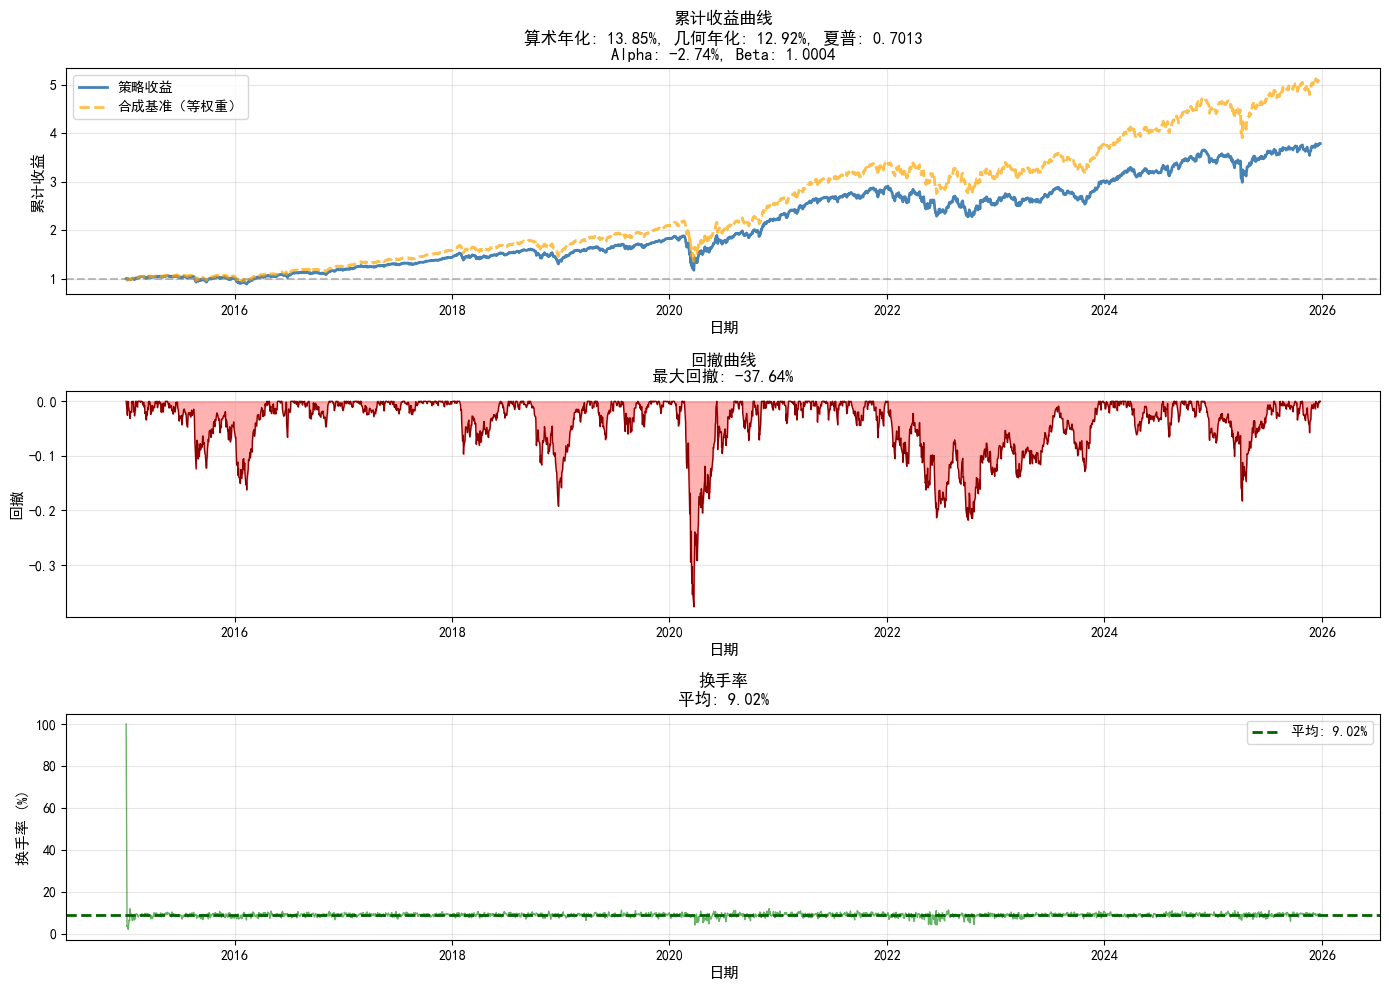

In [7]:
# 绘制累计收益曲线
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. 累计收益曲线
cumulative_ret = (1 + bt_results['ret_net']).cumprod()
axes[0].plot(cumulative_ret.index, cumulative_ret.values, linewidth=2, color='steelblue', label='策略收益')

# 绘制合成基准收益曲线（等权重组合）
common_dates = cumulative_ret.index.intersection(synthetic_benchmark.index)
if len(common_dates) > 0:
    benchmark_cumulative = (1 + synthetic_benchmark.loc[common_dates]).cumprod()
    axes[0].plot(benchmark_cumulative.index, benchmark_cumulative.values, 
                 linewidth=2, color='orange', linestyle='--', alpha=0.7, label='合成基准（等权重）')
    axes[0].legend(fontsize=10)

title = f'累计收益曲线\n算术年化: {metrics["annual_return_arithmetic"]*100:.2f}%, 几何年化: {metrics["annual_return_geometric"]*100:.2f}%, 夏普: {metrics["sharpe_ratio"]:.4f}'
if not pd.isna(metrics['alpha']):
    title += f'\nAlpha: {metrics["alpha"]*100:.2f}%, Beta: {metrics["beta"]:.4f}'
axes[0].set_title(title, fontsize=12, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=11)
axes[0].set_ylabel('累计收益', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(1, color='gray', linestyle='--', alpha=0.5)

# 2. 回撤曲线
cumulative = (1 + bt_results['ret_net']).cumprod()
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max
axes[1].fill_between(drawdown.index, drawdown.values, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown.values, linewidth=1, color='darkred')
axes[1].set_title(f'回撤曲线\n最大回撤: {metrics["max_drawdown"]*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=11)
axes[1].set_ylabel('回撤', fontsize=11)
axes[1].grid(True, alpha=0.3)

# 3. 换手率
axes[2].plot(bt_results['tvr'].index, bt_results['tvr'].values * 100, linewidth=1, color='green', alpha=0.6)
axes[2].axhline(avg_tvr * 100, color='darkgreen', linestyle='--', linewidth=2, label=f'平均: {avg_tvr*100:.2f}%')
axes[2].set_title(f'换手率\n平均: {avg_tvr*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[2].set_xlabel('日期', fontsize=11)
axes[2].set_ylabel('换手率 (%)', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 步骤 7: 因子 IC 和 IR 分析


计算因子 IC 和 IR...

因子 IC 和 IR 统计
IC 均值: 0.0061
IC 标准差: 0.1139
IR (信息比率): 0.0534
IC 正比例: 51.59%
有效观测数: 2762

绘制 IC 分布和时间序列...


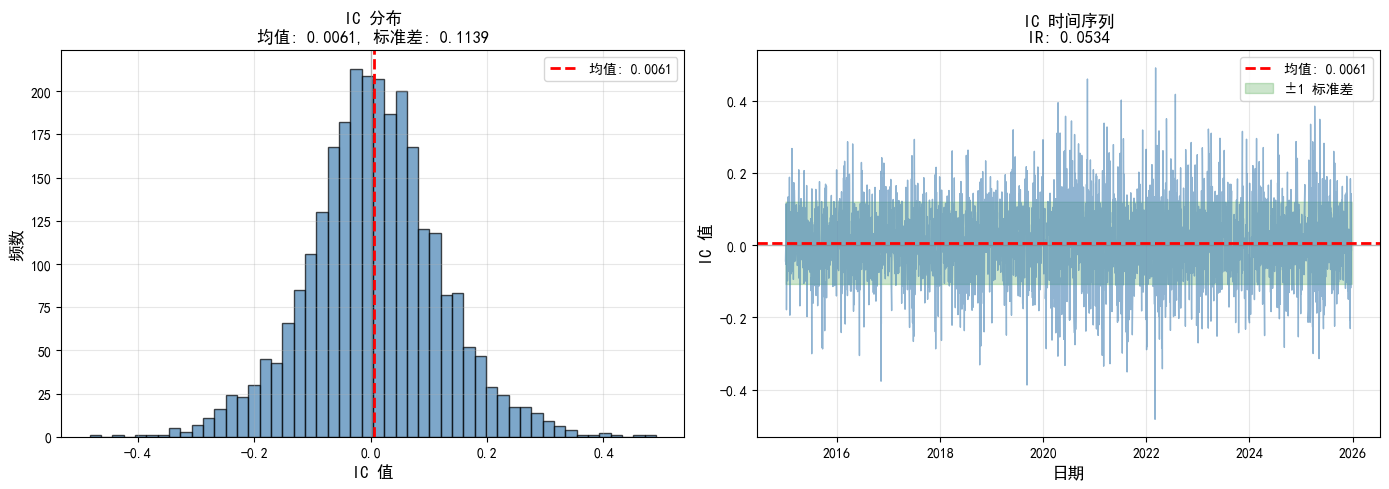

In [8]:
# 计算因子 IC（Information Coefficient）和 IR（Information Ratio）
print("计算因子 IC 和 IR...")

# 计算未来收益率（使用下一天的收益率）
forward_returns = data['close'].pct_change().shift(-1)

# 计算 IC（每日因子值与未来收益率的相关系数）
ic_series = calculate_ic(
    factor_values=factor_values,
    forward_returns=forward_returns,
    method='pearson'  # 使用皮尔逊相关系数
)

# 计算 IR（Information Ratio = IC均值 / IC标准差）
ir = calculate_ir(ic_series)

# 计算 IC 统计
ic_mean = ic_series.mean()
ic_std = ic_series.std()
ic_positive_ratio = (ic_series > 0).sum() / len(ic_series.dropna())

print("\n" + "=" * 60)
print("因子 IC 和 IR 统计")
print("=" * 60)
print(f"IC 均值: {ic_mean:.4f}")
print(f"IC 标准差: {ic_std:.4f}")
print(f"IR (信息比率): {ir:.4f}")
print(f"IC 正比例: {ic_positive_ratio*100:.2f}%")
print(f"有效观测数: {len(ic_series.dropna())}")
print("=" * 60)

# 绘制 IC 分布和时间序列
print("\n绘制 IC 分布和时间序列...")
plot_ic_distribution(ic_series)


## 步骤 8: 因子分位数分析


计算因子分位数收益（10组）...

因子分位数年化收益（10组）
Q1: 14.20%
Q2: 13.33%
Q3: 15.51%
Q4: 15.86%
Q5: 14.47%
Q6: 15.42%
Q7: 17.57%
Q8: 16.49%
Q9: 21.75%
Q10: 21.50%

多空收益 (Q10-Q1): 7.30%


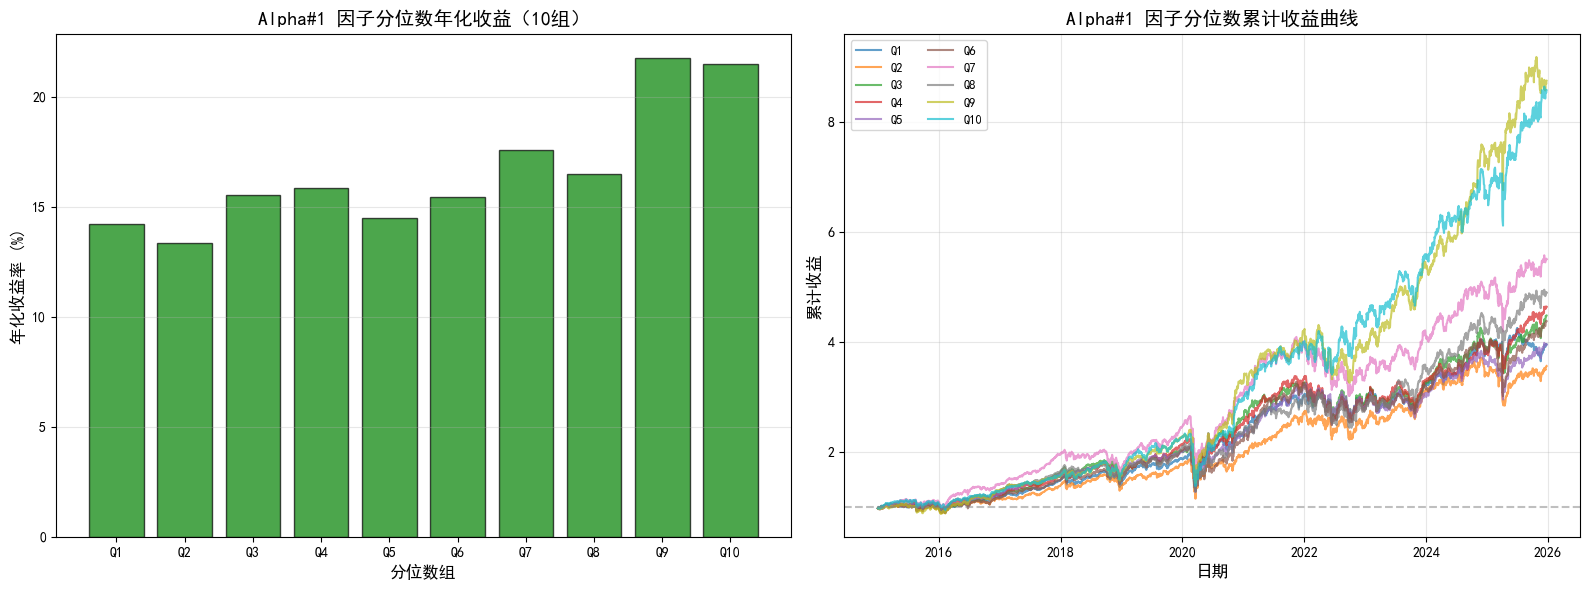


关键统计:
  最高分位 (Q10) 年化收益: 21.50%
  最低分位 (Q1) 年化收益: 14.20%
  多空收益 (Q10-Q1): 7.30%


In [9]:
# 因子分位数分析（10组）
print("计算因子分位数收益（10组）...")

# ✅ 修复：使用未来收益率（shift(-1)），确保因子值预测未来收益
forward_returns = data['close'].pct_change().shift(-1)

# 使用 factor_returns_by_quantile 计算分位数收益
quantile_returns = factor_returns_by_quantile(
    factor_values=factor_values,
    forward_returns=forward_returns,  # ✅ 使用未来收益率
    n_quantiles=10
)

# 计算年化收益（每日收益 * 252）
quantile_annual_returns = quantile_returns.mean() * 252

# 计算多空收益（最高分位 - 最低分位）
long_short_return = quantile_annual_returns.iloc[-1] - quantile_annual_returns.iloc[0]

print("\n" + "=" * 60)
print("因子分位数年化收益（10组）")
print("=" * 60)
for q in range(1, 11):
    if q in quantile_annual_returns.index:
        print(f"Q{q}: {quantile_annual_returns[q]*100:.2f}%")

print(f"\n多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
print("=" * 60)

# 可视化因子分位数收益
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 分位数年化收益柱状图
quantile_values = [quantile_annual_returns[q]*100 if q in quantile_annual_returns.index else 0 for q in range(1, 11)]

colors = ['red' if v < 0 else 'green' for v in quantile_values]
axes[0].bar(range(10), quantile_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Alpha#1 因子分位数年化收益（10组）', fontsize=14, fontweight='bold')
axes[0].set_xlabel('分位数组', fontsize=12)
axes[0].set_ylabel('年化收益率 (%)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([f'Q{i+1}' for i in range(10)])
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)

# 2. 分位数累计收益曲线
for q in range(1, 11):
    if q in quantile_returns.columns:
        cumulative = (1 + quantile_returns[q]).cumprod()
        axes[1].plot(cumulative.index, cumulative.values, 
                    label=f'Q{q}', linewidth=1.5, alpha=0.7)

axes[1].set_title('Alpha#1 因子分位数累计收益曲线', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('累计收益', fontsize=12)
axes[1].legend(loc='best', fontsize=9, ncol=2)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(1, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 打印关键统计
print("\n关键统计:")
print(f"  最高分位 (Q10) 年化收益: {quantile_annual_returns.iloc[-1]*100:.2f}%")
print(f"  最低分位 (Q1) 年化收益: {quantile_annual_returns.iloc[0]*100:.2f}%")
print(f"  多空收益 (Q10-Q1): {long_short_return*100:.2f}%")
